In [1]:
import torch
import torchaudio

from sklearn.model_selection import KFold
import numpy as np

from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.models import resnet34

from imblearn.over_sampling import SVMSMOTE as SSM

import matplotlib.pyplot as plt
import time

import pandas as pd

from ipynb.fs.defs.dataset_N import Data_set, AUDIO_DIR, ANNOTATIONS_FILE, SAMPLE_RATE, NUM_SAMPLES 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
## Parámetros

In [2]:
#Variables para "mel spectogram"
V_N_FFT = 1024
V_HOP_LENGTH = 256
V_N_MELS = 115

In [3]:
BATCH_SIZE = 150                  
EPOCHS = 100

LEARNING_RATE = 0.001 #0.001 0.01 0.0001

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


------------------------------------------------------------------------
------------------------------------------------------------------------


## Data set


In [5]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,
                                                       n_fft=V_N_FFT, hop_length=V_HOP_LENGTH,
                                                       n_mels=V_N_MELS)

dts = Data_set(ANNOTATIONS_FILE,
                   AUDIO_DIR,
                   SAMPLE_RATE,
                   NUM_SAMPLES,
                   device)

In [6]:
def create_dataloader(data_set, batch_size):
    dataloader = DataLoader(data_set, batch_size=batch_size, shuffle=True)
    return dataloader

--------------------------------------------------------------
--------------------------------------------------------------

## Balanceando Data_set

### Actualización de soportes de cada clase

In [7]:
def act_weights (data_set):
    Sop_clases = [0,0,0,0,0,0,0,0,0,0]
    Wgh_clases = []

    for i, (signal, label) in enumerate(data_set):
        Sop_clases[label] += 1
        
    max_sop = max(Sop_clases)
    
    for i in range(len(Sop_clases)):
        Wgh_clases.append(max_sop/Sop_clases[i])
        
    return Wgh_clases 

### Oversampling 

In [8]:
# Oversampling

def balance_dataloader(data_set,batch_size):
    
    print("Inicio balanceo: " + time.ctime())
    
    weights = act_weights(data_set)
    
    sample_weight = [0]*len(data_set)
    
    for idx, (signal, label) in enumerate(data_set):
        sample_weight[idx] = weights[label]
    
    new_sampler = WeightedRandomSampler(sample_weight, num_samples = len(sample_weight), replacement = True)
    
    dataloader = DataLoader(data_set, batch_size = batch_size, sampler = new_sampler)
    
    print("Terminó balanceo: " + time.ctime())
    
    return dataloader   

### Balancear todo nuestro conjunto de datos

In [9]:
def balance_dataset (dataset, transform, device):
    
    transform = transform.to(device)
    
    signal = torch.tensor([])
    label=[]
    dts = []
    
    print("Inicio del balanceo total: " + time.ctime())
    
    for i, (X, y) in enumerate(dataset):
        signal= torch.cat((signal,X.to('cpu')), 0)
        label.append(y)
        
    print("Proceso SVMSMOTE: " + time.ctime())
    
    sm = SSM()
    
    signal_res, label_res = sm.fit_resample(signal, label)
    
    print("Nueva data_set: " + time.ctime())
        
    for i in range(len(signal_res)):
        sgl=torch.tensor(signal_res[i],device=device)
        sgl_tf=transform(sgl).unsqueeze(0)
        dts.append([sgl_tf, label_res[i]])
        
    print("Final del balanceo total: " + time.ctime())
        
    
    return dts

-----------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------
## Entrenamiento

In [10]:
def train(model, data_loader, loss_fn, optimizer, device, epochs):
    
    model.train()
    
    print("Inicio del entrenamiento: " + time.ctime())
    loss = 1
    i = 0
    EPS = 0.0003
    while i in range(epochs) and loss > EPS:
        loss = train_single_epoch(model, data_loader, loss_fn, optimizer, device)

    print("Término del entrenamiento: " + time.ctime())

In [11]:
def train_single_epoch(model, data_loader, loss_fn, optimizer, device):

    for input, label in data_loader:
        input, label = input.to(device), label.to(device)
        
        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, label)

        # backpropagate error and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    return loss.item()

### Modelo ResNet34

In [12]:
resnet34_model = resnet34(pretrained=True)
resnet34_model.fc = nn.Linear(512, 10)
resnet34_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet34_model = resnet34_model.to(device)

cnn = resnet34_model

### Función optimización y perdida

In [13]:
loss_fn = nn.CrossEntropyLoss()

optimizer= torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------

## Implementación

In [14]:
def create_targets_predictions (model, data_loader, device):
    
    labels, predictions = [],[]
    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)
          
            predic = model(input)
            predicted_class = predic.argmax(1)

            #np array
            prdc = predicted_class.to('cpu')
            target = target.to('cpu')
            prdc = prdc.numpy()
            target = target.numpy()


            for i in range(len(prdc)):
                predictions.append(prdc[i])
                labels.append(target[i])

    return labels, predictions

In [15]:
def eval_model (model, data_loader, device, LABEL_CNN):
    
    print("Inicio de la evaluación: " + time.ctime())
    
    labels, predictions = create_targets_predictions(model, data_loader, device)
    
    accuracy = accuracy_score(labels, predictions)
    
    classes = ["AC", "car horn", "childrens", "dog bark", "drilling", "engine", "gun shot", "jackhammer", "siren", "street music"]
    
    report = classification_report(labels, predictions, target_names=classes, output_dict=True)
    
    cm = confusion_matrix(labels, predictions)
    
    #Guardamos la Matriz de confusión
    disp = ConfusionMatrixDisplay(cm,classes)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation=90)
    plt.tight_layout()
    plt.savefig('MC_'+LABEL_CNN+".png")
    
    
    print("Término de la evaluación: " + time.ctime())
    
    return accuracy, report

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
## KFold

In [16]:
def train_kfold(model, data_set, k_fold, batch_size, loss_fn, optimizer, device, epochs):
    
    acc = []
    
    
    #balanceo
    dts = balance_dataset(data_set, mel_spectrogram, device)
    
    #Division KFold
    k_fold_num = k_fold.split(np.arange(len(dts)))
    
    for fold, (Ent_idx, Eval_idx) in enumerate (k_fold_num):
        
        #Division del dataset
        Ent_dts = torch.utils.data.Subset(dts, Ent_idx)
        Eval_dts = torch.utils.data.Subset(dts, Eval_idx)
        
        #DataLoader
#         DataLoader_Ent = balance_dataloader(Ent_dts, batch_size)
        DataLoader_Ent = create_dataloader(Ent_dts, batch_size)
        DataLoader_Eval = create_dataloader(Eval_dts, batch_size)
        
        #Entrenamiento
        train(model, DataLoader_Ent, loss_fn, optimizer,device, epochs)
        
        #Salvar el modelo entrenado
        LABEL_CNN = 'ResNet34_KFold_001_'+str(fold+1)
        torch.save(model.state_dict(), LABEL_CNN + ".pth")
        
        #Evaluación
        accuracy, report = eval_model(model, DataLoader_Eval, device, LABEL_CNN)
        
        #Guardamos el reporte
        df = pd.DataFrame(report).transpose().round(2)
        df.to_csv('Resumen_'+LABEL_CNN+'.csv')
        
        
        #acc
        acc.append(accuracy*100)

        
        #Mostrar información
        print(LABEL_CNN)
        print('Numero de folder: '+ str(fold+1))
        print('Precisión del modelo: '+ str("{0:.2f}".format(accuracy*100))+'%')
        print('')
        
    return acc

Inicio del balanceo total: Wed Apr 19 20:42:26 2023
Proceso SVMSMOTE: Wed Apr 19 21:03:37 2023
Nueva data_set: Wed Apr 19 22:11:49 2023
Final del balanceo total: Wed Apr 19 22:13:04 2023
Inicio del entrenamiento: Wed Apr 19 22:13:07 2023
Término del entrenamiento: Wed Apr 19 23:28:29 2023
Inicio de la evaluación: Wed Apr 19 23:28:30 2023


D:\Programas\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=['AC', 'car horn', 'childrens', 'dog bark', 'drilling', 'engine', 'gun shot', 'jackhammer', 'siren', 'street music'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Término de la evaluación: Wed Apr 19 23:28:38 2023
ResNet34_KFold_0001_1
Numero de folder: 1
Precisión del modelo: 70.28%

Inicio del entrenamiento: Wed Apr 19 23:28:39 2023
Término del entrenamiento: Wed Apr 19 23:48:00 2023
Inicio de la evaluación: Wed Apr 19 23:48:01 2023


D:\Programas\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=['AC', 'car horn', 'childrens', 'dog bark', 'drilling', 'engine', 'gun shot', 'jackhammer', 'siren', 'street music'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Término de la evaluación: Wed Apr 19 23:48:04 2023
ResNet34_KFold_0001_2
Numero de folder: 2
Precisión del modelo: 77.53%

Inicio del entrenamiento: Wed Apr 19 23:48:04 2023
Término del entrenamiento: Wed Apr 19 23:56:51 2023
Inicio de la evaluación: Wed Apr 19 23:56:51 2023


D:\Programas\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=['AC', 'car horn', 'childrens', 'dog bark', 'drilling', 'engine', 'gun shot', 'jackhammer', 'siren', 'street music'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Término de la evaluación: Wed Apr 19 23:56:58 2023
ResNet34_KFold_0001_3
Numero de folder: 3
Precisión del modelo: 85.80%

Inicio del entrenamiento: Wed Apr 19 23:56:58 2023
Término del entrenamiento: Thu Apr 20 00:08:42 2023
Inicio de la evaluación: Thu Apr 20 00:08:42 2023


D:\Programas\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=['AC', 'car horn', 'childrens', 'dog bark', 'drilling', 'engine', 'gun shot', 'jackhammer', 'siren', 'street music'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Término de la evaluación: Thu Apr 20 00:08:45 2023
ResNet34_KFold_0001_4
Numero de folder: 4
Precisión del modelo: 56.23%

Inicio del entrenamiento: Thu Apr 20 00:08:45 2023
Término del entrenamiento: Thu Apr 20 00:36:54 2023
Inicio de la evaluación: Thu Apr 20 00:36:54 2023


D:\Programas\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=['AC', 'car horn', 'childrens', 'dog bark', 'drilling', 'engine', 'gun shot', 'jackhammer', 'siren', 'street music'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Término de la evaluación: Thu Apr 20 00:36:57 2023
ResNet34_KFold_0001_5
Numero de folder: 5
Precisión del modelo: 54.47%



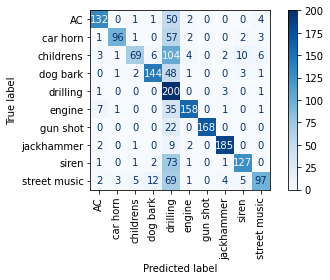

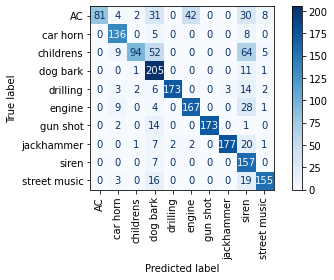

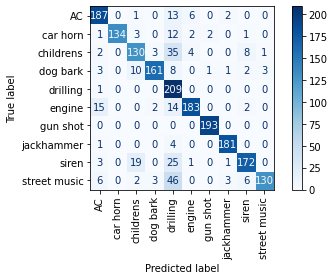

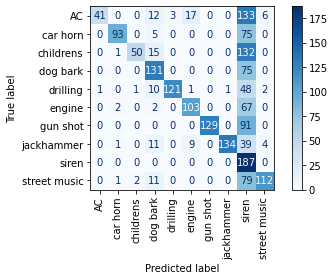

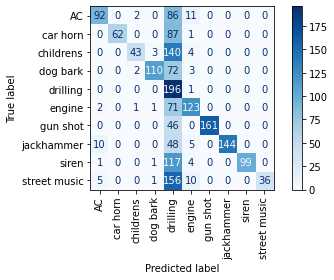

In [17]:
k_fold = KFold(n_splits=5,shuffle=True)

acc = train_kfold(cnn, dts, k_fold, BATCH_SIZE, loss_fn, optimizer, device, EPOCHS)

---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------

## Resultados

In [18]:
print(acc, np.mean(acc))

[70.27579162410623, 77.52808988764045, 85.80183861082737, 56.23084780388151, 54.471129279509455] 68.861539441193
